# k-Nearest Neighbors (Continued)

In [3]:
from Week05R import *

b
b


We’d like to plot the measurements so we can see how they vary by species. Unfortunately,
they are four-dimensional, which makes them tricky to plot. One thing we can
do is look at the scatterplots for each of the six pairs of measurements.

Note that the following code snippet contains a lot more details than what you are required to know. But it can be worth studying if you are interested in the more complicated things that `matplotlib` can do.

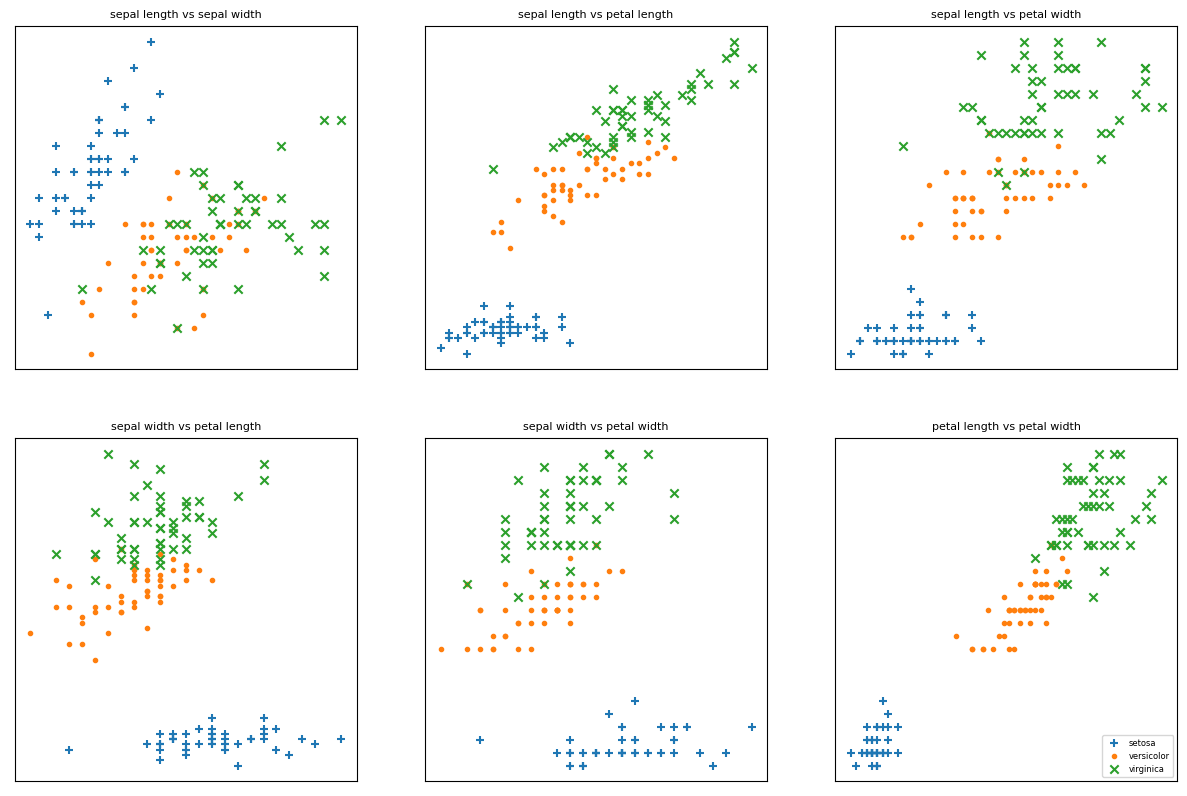

In [17]:
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100

metrics = ['sepal length', 'sepal width', 'petal length', 'petal width']
pairs = [(i, j) for i in range(4) for j in range(4) if i < j]
marks = ['+', '.', 'x']  # we have 3 classes, so 3 markers

fig, ax = plt.subplots(2, 3)

for row in range(2):
    for col in range(3):
        i, j = pairs[3 * row + col]
        ax[row][col].set_title(f"{metrics[i]} vs {metrics[j]}", fontsize=8)
        ax[row][col].set_xticks([])
        ax[row][col].set_yticks([])

        for mark, (species, points) in zip(marks, points_by_species.items()):
            xs = [point[i] for point in points]
            ys = [point[j] for point in points]
            ax[row][col].scatter(xs, ys, marker=mark, label=species)

ax[-1][-1].legend(loc='lower right', prop={'size': 6})
plt.show()

If you look at those plots, it seems like the measurements really do cluster by species.
For example, looking at sepal length and sepal width alone, you probably couldn’t distinguish
between versicolor and virginica. But once you add petal length and width
into the mix, it seems like you should be able to predict the species based on the nearest
neighbors.

To start with, let’s split the data into a test set and a training set:

In [5]:
import random
from typing import TypeVar, Tuple
X = TypeVar('X')  # generic type to represent a data point

def split_data(data: List[X], prob: float) -> Tuple[List[X], List[X]]:
    """Split data into fractions [prob, 1 - prob]"""
    data = data[:]                    # Make a shallow copy
    random.shuffle(data)              # because shuffle modifies the list.
    cut = int(len(data) * prob)       # Use prob to find a cutoff
    return data[:cut], data[cut:]     # and split the shuffled list there.

random.seed(12)
iris_train, iris_test = split_data(iris_data, 0.70)
print(len(iris_train))
print(len(iris_test))

105
45


The training set will be the “neighbors” that we’ll use to classify the points in the test set. We just need to choose a value for k, the number of neighbors who get to vote. Too small (think k = 1), and we let outliers have too much influence; too large (think k = 105), and we just predict the most common class in the dataset. Here we’ll just use k = 5:

In [6]:
# track how many times we see (predicted, actual)
confusion_matrix: Dict[Tuple[str, str], int] = defaultdict(int)
num_correct = 0

for iris in iris_test:
    predicted = knn_classify(5, iris_train, iris.point)
    actual = iris.label

    if predicted == actual:
        num_correct += 1

    confusion_matrix[(predicted, actual)] += 1

pct_correct = num_correct / len(iris_test)
print(f"accuracy = {pct_correct * 100}%")
print(f"confusion_matrix = {confusion_matrix}")

accuracy = 97.77777777777777%
confusion_matrix = defaultdict(<class 'int'>, {('setosa', 'setosa'): 13, ('versicolor', 'versicolor'): 15, ('virginica', 'virginica'): 16, ('virginica', 'versicolor'): 1})


On this simple dataset, the model predicts almost perfectly. There’s one versicolor for
which it predicts virginica, but otherwise it gets things exactly right.

## The Curse of Dimensionality

The k-nearest neighbors algorithm runs into trouble in higher dimensions thanks to
the “curse of dimensionality,” which boils down to the fact that high-dimensional
spaces are vast. Points in high-dimensional spaces tend not to be close to one another
at all.

One way to see this is by randomly generating pairs of points in the d-dimensional
“unit cube” in a variety of dimensions, and calculating the distances
between them.

Generating random points should be second nature by now:

In [7]:
def random_point(dim: int) -> Vector:
    return [random.random() for _ in range(dim)]

as is writing a function to generate the distances:

In [8]:
def random_distances(dim: int, num_pairs: int) -> List[float]:
    return [distance.euclidean(random_point(dim), random_point(dim))
            for _ in range(num_pairs)]

For every dimension from 1 to 100, we’ll compute 10,000 distances and use those to
compute the average distance between points and the minimum distance between
points in each dimension:

In [9]:
import tqdm
dimensions = range(1, 101)

avg_distances = []
min_distances = []

random.seed(0)
for dim in tqdm.tqdm(dimensions, desc="Curse of Dimensionality"):
    distances = random_distances(dim, 10000)      # 10,000 random pairs
    avg_distances.append(sum(distances) / 10000)  # track the average
    min_distances.append(min(distances))          # track the minimum

Curse of Dimensionality: 100%|███████████████████████████████████████████████████████| 100/100 [00:21<00:00,  4.72it/s]


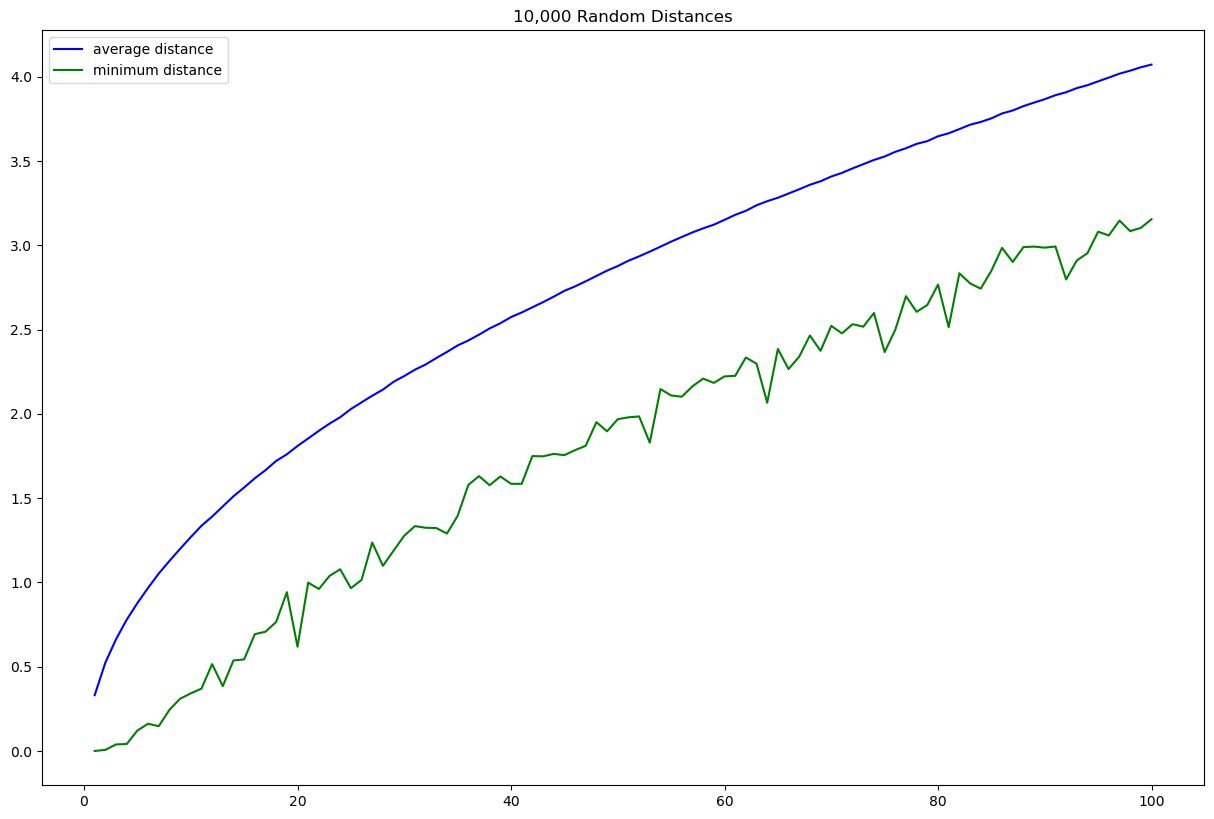

In [10]:
plt.plot(dimensions, avg_distances, color='blue', label="average distance")
plt.plot(dimensions, min_distances, color='green', label="minimum distance")
plt.title("10,000 Random Distances")
plt.legend()
plt.show()

As the number of dimensions increases, the average distance between points increases.
But what’s more problematic is the ratio between the closest distance and the
average distance:

In [11]:
min_avg_ratio = [min_dist / avg_dist for min_dist, avg_dist in zip(min_distances, avg_distances)]

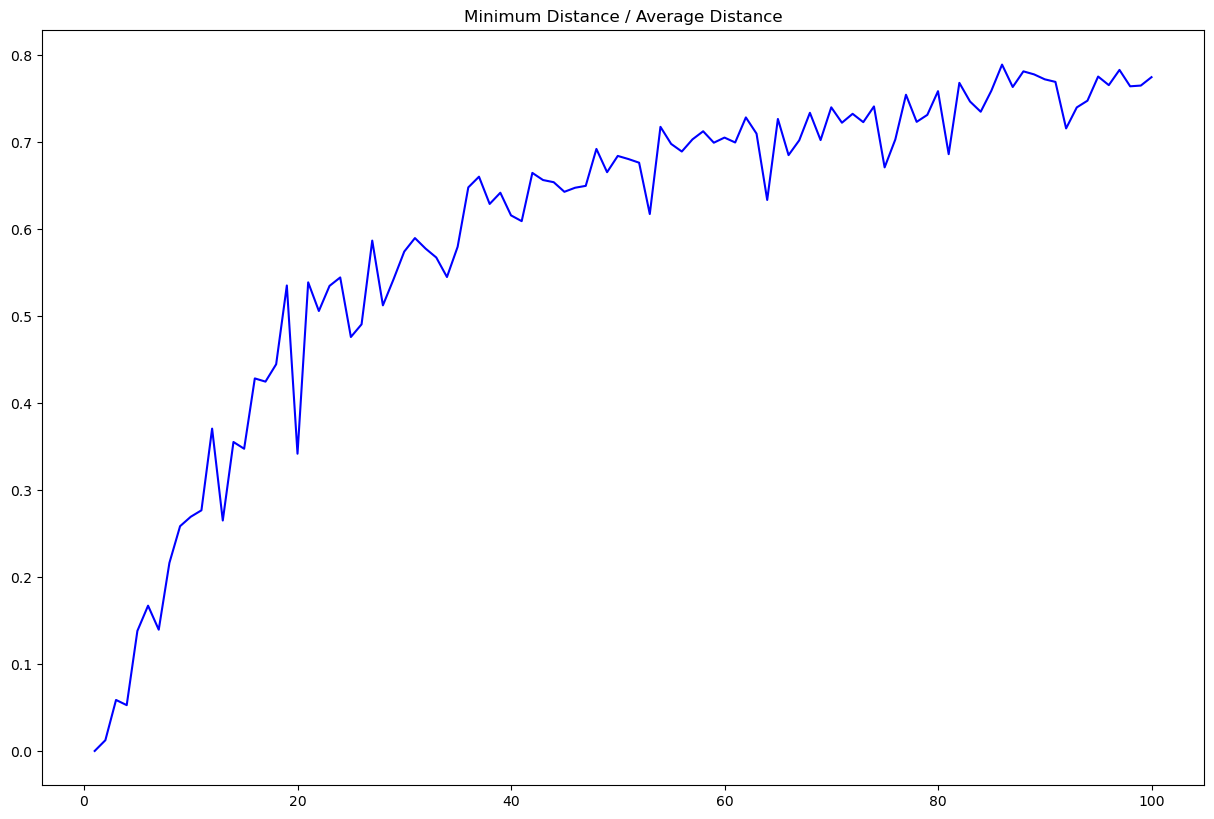

In [12]:
plt.plot(dimensions, min_avg_ratio, color='blue')
plt.title("Minimum Distance / Average Distance")
plt.show()

In low-dimensional datasets, the closest points tend to be much closer than average.
But two points are close only if they’re close in every dimension, and every extra
dimension—even if just noise—is another opportunity for each point to be farther
away from every other point. When you have a lot of dimensions, it’s likely that the
closest points aren’t much closer than average, so two points being close doesn’t mean
very much.

A different way of thinking about the problem involves the sparsity of higher dimensional
spaces.

If you pick 50 random numbers between 0 and 1, you’ll probably get a pretty good
sample of the unit interval

![Fifty random points in one dimension](50d1.jpg)

If you pick 50 random points in the unit square, you’ll get less coverage

![Fifty random points in two dimensions](50d2.jpg)

And in three dimensions, less still

![Fifty random points in three dimensions](50d3.jpg)

`matplotlib` (or any other package) doesn’t graph four dimensions well, so that’s as far as we’ll go, but you can
see already that there are starting to be large empty spaces with no points near them.

In more dimensions—unless you get exponentially more data—those large empty
spaces represent regions far from all the points you want to use in your predictions.

So if you’re trying to use nearest neighbors in higher dimensions, it’s probably a good
idea to do some kind of dimensionality reduction first (e.g., Principle Component Analysis, which we will discuss later).